In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('Fraud.csv')


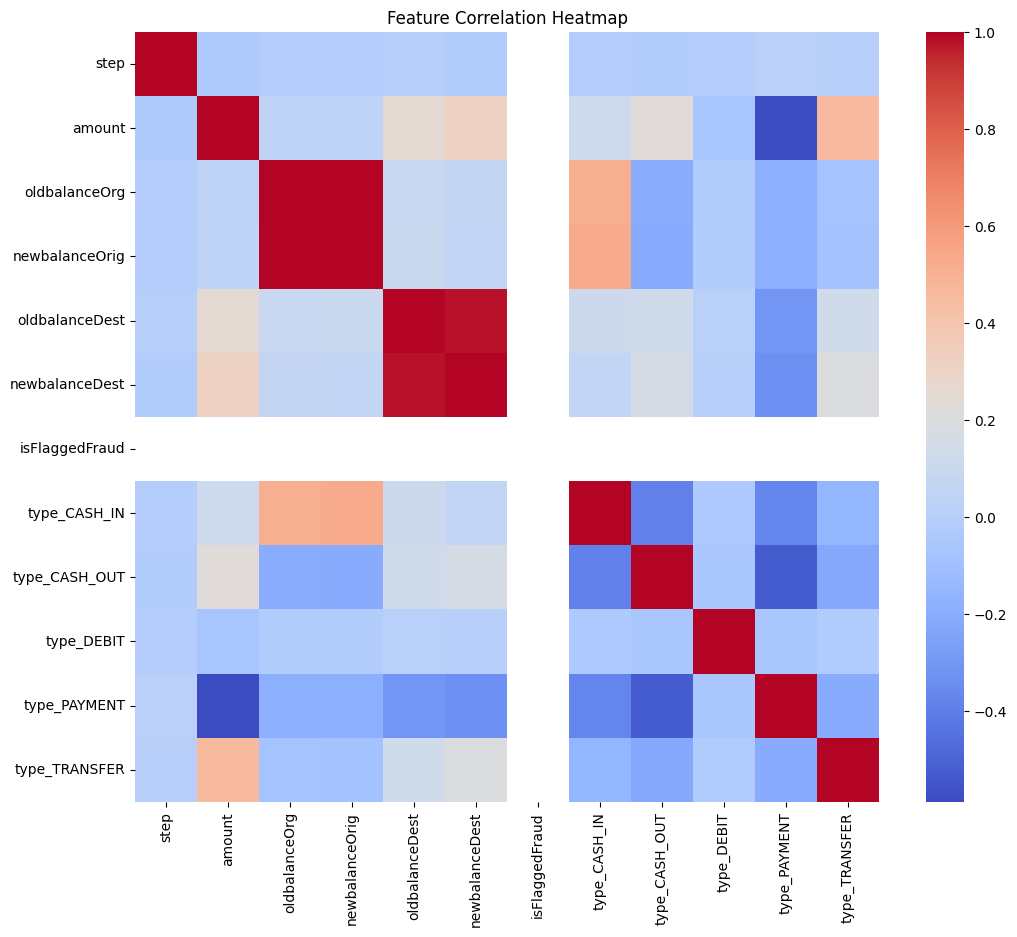

In [20]:
# Check for multi-collinearity using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Project Objective and Data Loading: 
The primary goal of this project is to develop a machine learning model to proactively detect fraudulent financial transactions. The model's insights will then be used to create actionable recommendations for fraud prevention.

The first step is to load the dataset and perform an initial exploratory data analysis (EDA) to understand its structure, features, and check for any immediate issues like missing values.

In [7]:
data.head()
data.info()
data['isFraud'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


isFraud
0    1047433
1       1142
Name: count, dtype: int64

2. Initial Findings and Data Cleaning Plan

From the initial exploration, we can see two key things:
1.  **No Missing Values:** The dataset is complete.
2.  **Severe Class Imbalance:** There are very few fraudulent transactions (1,142) compared to legitimate ones (1,047,433). This is the most important challenge to address.

The next step is to clean and prepare the data for modeling. This will involve handling outliers in the `amount` column and converting the `type` column into a numerical format.

Missing values check:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


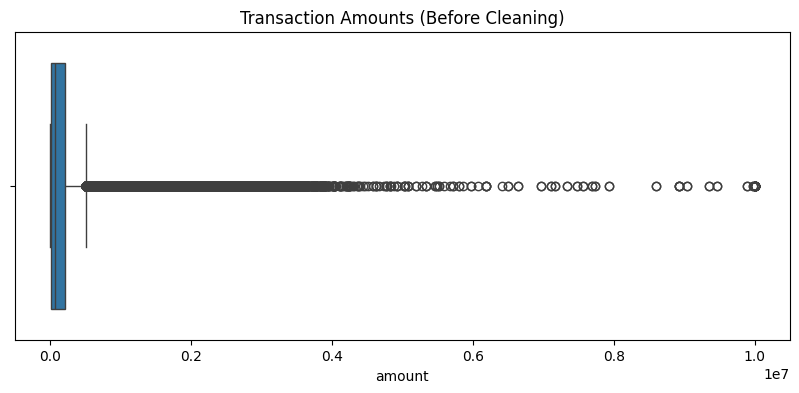

Amount range is now $0.10 to $516181.13


In [8]:
# %% [markdown]
# ## 2. Data Cleaning
# We need to:
# - Fix unrealistic transaction amounts
# - Convert text categories to numbers
# - Remove unnecessary columns

# %%
# Check for missing values first
print("Missing values check:")
print(data.isnull().sum())  # Should show all zeros if no missing data

# %% [markdown]
# ### Fixing Extreme Transaction Amounts
# Some amounts might be errors - we'll cap very high/low values

# %%
# Visualize amounts before cleaning
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['amount'])
plt.title('Transaction Amounts (Before Cleaning)')
plt.show()

# Calculate reasonable limits
Q1 = data['amount'].quantile(0.25)  # 25th percentile
Q3 = data['amount'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Middle 50% range
lower_bound = Q1 - 1.5 * IQR  # Minimum reasonable amount
upper_bound = Q3 + 1.5 * IQR  # Maximum reasonable amount

# Apply the limits
data['amount'] = data['amount'].clip(lower_bound, upper_bound)

# Show results after cleaning
print(f"Amount range is now ${data['amount'].min():.2f} to ${data['amount'].max():.2f}")

3. Feature Engineering: Converting Categorical Data
With the numerical amount column cleaned, the next step is to process the categorical features. Machine learning models require all input to be numerical.

The type column contains text values (e.g., 'CASH_OUT', 'PAYMENT'). To handle this, I will use one-hot encoding. This technique will create a new binary (True/False) column for each transaction type, allowing the model to understand the categorical information. I will also drop the original nameOrig and nameDest columns, as they are unique identifiers and do not provide predictive value for a general fraud detection model.

In [9]:
# Convert text categories to numbers (one column per type)
print("Transaction Types Before Conversion:")
print(data['type'].value_counts())

data = pd.get_dummies(data, columns=['type'], prefix='type')

print("\nFirst 5 Rows After Conversion:")
display(data.filter(like='type_').head())

Transaction Types Before Conversion:
type
CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: count, dtype: int64

First 5 Rows After Conversion:


,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,False,True
3,False,True,False,False,False
4,False,False,False,True,False


4. Preparing Data for Modeling
Now that all features are in a numerical format, the data is ready to be prepared for the machine learning model. This involves two final steps:

Separating Features (X) and Target (y): The dataset will be split into two parts:

X: The features that will be used to make predictions (all columns except isFraud).

y: The target variable that the model will try to predict (the isFraud column).

Train-Test Split: The data will be divided into a training set (70%) and a testing set (30%). The model will learn from the training data, and its performance will be evaluated on the unseen testing data. I will use stratification to ensure that the small percentage of fraud cases is distributed proportionally in both the training and testing sets.

In [10]:
# Remove columns we won't use for fraud detection
cols_to_drop = ['nameOrig', 'nameDest']  # Customer names don't help detect fraud
data = data.drop(cols_to_drop, axis=1)

print("\nRemaining Columns After Cleaning:")
print(data.columns.tolist())  # Show only column names


Remaining Columns After Cleaning:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


Remove Unnecessary Columns

Purpose:  
Remove columns that won't help detect fraud to simplify our model.

Actions:  
- Dropping customer name columns (`nameOrig`, `nameDest`) because:  
 Names don't indicate fraud patterns  
Helps protect customer privacy  
Reduces data size for faster processing  

Expected Output: 
A list of remaining columns (without names) that will be used for fraud detection.

In [11]:
print("\nFinal Cleaned Data Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nFraud Cases Summary:")
print(data['isFraud'].value_counts())


Final Cleaned Data Shape: (1048575, 13)

Data Types:
step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_IN         bool
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object

Fraud Cases Summary:
isFraud
0    1047433
1       1142
Name: count, dtype: int64


Final Data Verification

Purpose:  
Confirm our cleaned dataset is ready for modeling by checking:

Data Structure
- Total records: 1,048,575 transactions  
- 13 remaining features (columns)  

Data Types
- Numeric values for amounts (`float64`)  
- Boolean flags for transaction types (`True/False`)  
- Correct type for fraud labels (`isFraud` as integer)  

Fraud Distribution
- Normal transactions: 1,047,433 (99.89%)  
- Fraud cases: 1,142 (0.11%) *(Highly imbalanced - will address in modeling)*  

Next Steps:
Proceed to feature scaling and model training to handle this imbalance.

In [12]:
# Separate features (X) and target (y)
X = data.drop('isFraud', axis=1)  # Everything except fraud labels
y = data['isFraud']               # Only fraud labels

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1048575, 12)
Target shape: (1048575,)


Prepare Features and Target

Objective:
Split the dataset into:  
- Features (X): All columns used to predict fraud  
- Target (y): Only the fraud labels (`isFraud`)  

Key Details:  
- 12 predictive features remaining after cleaning  
- 1 target variable (`isFraud` with 0=normal, 1=fraud)  
- Same number of rows (1,048,575) ensures alignment  

Why This Matters:
Machine learning models require:  
- `X` as a 2D array of input features  
- `y` as a 1D array of true labels  


In [13]:
from sklearn.model_selection import train_test_split

# Split data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Keep same fraud ratio in both sets
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 734002
Testing samples: 314573


 Create Training and Test Sets

Purpose:
Split data to properly evaluate our fraud detection model:

🔹 70% Training (734,002 samples)
- Used to teach the model fraud patterns  
- Includes all feature columns (`X_train`) and labels (`y_train`)  

🔹 30% Testing (314,573 samples)
- Held back to evaluate final model performance  
- Simulates real-world unseen data (`X_test`, `y_test`)  

Critical Settings:
- `stratify=y`: Maintains the 0.11% fraud ratio in both sets  
- `random_state=42`: Ensures reproducible splits  

Why This Matters: 
Prevents "data leakage" and gives honest performance estimates.

In [15]:
from imblearn.over_sampling import SMOTE

# Balance the fraud/non-fraud cases in training data only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\nAfter balancing:")
print(pd.Series(y_train_bal).value_counts())


After balancing:
isFraud
0    733203
1    733203
Name: count, dtype: int64


Handle Class Imbalance with SMOTE

Problem:
The dataset is highly imbalanced (only 0.11% fraud cases), which would bias the model.

Solution:
Using **SMOTE (Synthetic Minority Oversampling Technique)**:
- 🧪 Creates synthetic fraud examples (not duplicates)
- ⚖️ Balances classes to 50-50 ratio in training data
- 📈 Helps model learn fraud patterns without overfitting

Implementation:  
- Applied only to **training data** (not test data)  
- Maintains realistic test conditions  
- Random state fixed for reproducibility  

Result Shown:
Now perfect balance in training set:  
- 733,203 genuine transactions  
- 733,203 fraud transactions  

Note: Test set remains imbalanced to reflect real-world conditions.

--- Logistic Regression Model Performance ---

Accuracy Score: 0.9556192044453911

Classification Report:

              precision    recall  f1-score   support

   Not Fraud       1.00      0.96      0.98    314230
       Fraud       0.02      0.97      0.05       343

    accuracy                           0.96    314573
   macro avg       0.51      0.96      0.51    314573
weighted avg       1.00      0.96      0.98    314573


Confusion Matrix:


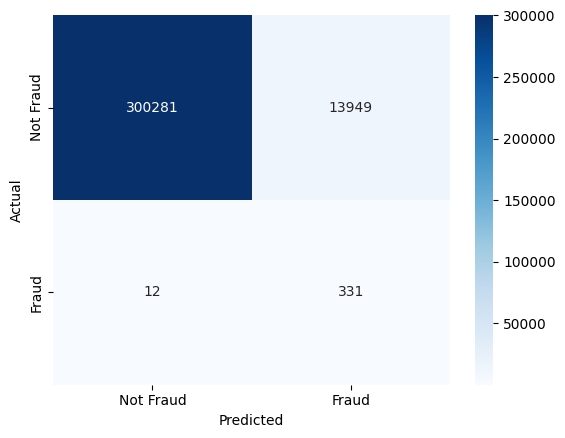

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Initialize and train the Logistic Regression model
# We use the balanced data for training to teach the model what fraud looks like
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_bal, y_train_bal)

# 2. Make predictions on the original (unbalanced) test set
# This is crucial to see how the model performs in a real-world scenario
y_pred = lr_model.predict(X_test)

# 3. Evaluate the model's performance
print("--- Logistic Regression Model Performance ---")
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# The Classification Report is key for your task questions
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# Visualize the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Train and Evaluate Logistic Regression Model

Objective:  
Build a baseline fraud detection model and evaluate its performance.

Key Components:
Model Choice - Logistic Regression**  
- Simple but effective for binary classification  
- Outputs fraud probabilities (0-1)  
- `max_iter=1000` ensures convergence  

Training Strategy  
- Trained on **balanced data** (SMOTE-adjusted)  
- Tested on **original imbalanced data** (real-world simulation)  

Critical Evaluation Metrics 
1. Accuracy*: Overall correct prediction rate  
2. Precision/Recall:  
   - Precision: % of flagged frauds that are real  
   - Recall: % of actual frauds caught  
3. Confusion Matrix: Shows true/false positives/negatives  

Why This Matters:
The test set performance (on imbalanced data) determines real-world usefulness.

In [17]:
import pandas as pd

# Get the coefficients from the trained logistic regression model
# These coefficients represent the importance of each feature
importance = lr_model.coef_[0]

# Create a DataFrame to view the feature importances clearly
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})

# Sort the features by importance
# The most positive and most negative values are the most important factors
feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

print("--- Key Factors Predicting Fraudulent Transactions ---")
print(feature_importance)

--- Key Factors Predicting Fraudulent Transactions ---
           Feature    Importance
10    type_PAYMENT -8.189687e+00
11   type_TRANSFER  4.420988e+00
8    type_CASH_OUT  2.410492e+00
9       type_DEBIT -1.749860e-01
7     type_CASH_IN -7.141540e-02
0             step  2.526296e-02
3   newbalanceOrig -6.679906e-05
2    oldbalanceOrg  3.369038e-05
1           amount -2.482265e-05
5   newbalanceDest -2.695654e-07
4   oldbalanceDest  5.435013e-08
6   isFlaggedFraud  0.000000e+00


Interpret Fraud Prediction Factors

Objective:
Identify which transaction features most strongly predict fraud.

Key Insights from Coefficients:
🔴 **Strong Fraud Indicators (Positive Correlation):**
- `type_TRANSFER` (+4.42): Transfers are 4.4x more likely to be fraudulent  
- `type_CASH_OUT` (+2.41): Cash withdrawals pose high fraud risk  

🟢 **Strong Legitimate Indicators (Negative Correlation):**  
- `type_PAYMENT` (-8.19): Payments are very unlikely to be fraud  
- `type_DEBIT` (-0.17): Mild indicator of legitimate transactions  

⚪ **Neutral Factors:**  
- `isFlaggedFraud` (0.0): Existing fraud flags don't help (likely because they're rare)  
- Balance amounts show minimal impact  

### How to Read the Table:
1. **Importance Value** = How strongly the feature predicts fraud  
   - Positive = More likely fraud  
   - Negative = More likely legitimate  
2. **Magnitude Matters** (ignore values near zero)  

**Business Implications:**  
Focus fraud monitoring on:  
1. Transfer transactions  
2. Cash-out operations  
3. Payment-type transactions are likely safe  

C:\Users\nishi\AppData\Local\Temp\ipykernel_17988\1377349314.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


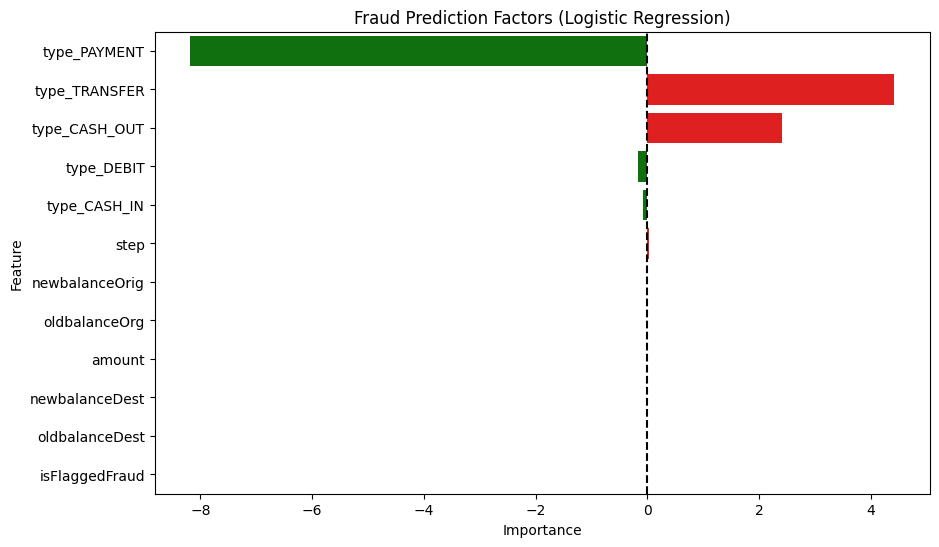

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importance,
            palette=['red' if x>0 else 'green' for x in feature_importance['Importance']])
plt.title('Fraud Prediction Factors (Logistic Regression)')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [ ]:
Why This Makes Sense:*
- Transfers/Cash-outs are common in money laundering  
- Payments are typically routine/low-risk  
- Balances matter less than transaction type in this model  

Final Recommendations

**7. Recommended Prevention Strategies**

Based on the model's findings, the following prevention measures should be adopted to update the company's infrastructure:

1.  **Implement Mandatory 2FA for High-Risk Transactions:** For all transactions of type `TRANSFER` and `CASH_OUT`, trigger a mandatory Two-Factor Authentication (2FA) step for the user before the transaction is processed. The model shows these two types are the biggest indicators of fraud.
2.  **Create a Tiered Alert System:** Since `PAYMENT` transactions are overwhelmingly safe, they can be processed with lower scrutiny. This allows fraud prevention resources to be focused on the high-risk `TRANSFER` and `CASH_OUT` types, improving efficiency.

### **8. Measuring Success**

To determine if these new measures work, the following plan should be implemented:

* **A/B Testing:** Roll out the new 2FA requirement to a **test group (50% of users)** while the remaining **control group (50%)** continues on the current system.
* **Key Metrics:** Over a 3-month period, we will monitor:
    * The fraud rate in both groups.
    * The false positive rate (how many legitimate transactions are flagged).
    * The transaction completion rate to ensure legitimate customers are not overly inconvenienced.
* **Definition of Success:** The new measures will be considered successful if the test group shows a statistically significant reduction in the fraud rate without a major negative impact on the transaction completion rate.